<a href="https://colab.research.google.com/github/Comfortxble/UROP-ABCD/blob/main/DT_rsfMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load Packages**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/vir_env/lib/python3.13/site-packages")

In [ ]:
#Loading other packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.model_selection import RepeatedStratifiedKFold

# **Combined Psychosical and fMRI**

## **Load Data + Data Separation**

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/UROP Data/sa_ppc_rsfMRI_train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/UROP Data/sa_ppc_rsfMRI_test.csv")

In [ ]:
y = df['SuicideAttempt']
X = df.drop(['SuicideAttempt', 'subjectkey'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
# stratify=y to mediate data imbalance

y_test = df_test['SuicideAttempt']
X_test = df_test.drop(['SuicideAttempt', 'subjectkey'], axis=1)

In [ ]:
# Questionaire ONLY
X_train_q = X_train.iloc[:, 0:130]
X_valid_q = X_valid.iloc[:, 0:130]
X_test_q = X_test.iloc[:, 0:130]

# fMRI ONLY
X_train_mri = X_train.iloc[:, 130::]
X_valid_mri = X_valid.iloc[:, 130::]
X_test_mri = X_test.iloc[:, 130::]

In [ ]:
# is the data balanced? since there's only 1s and 0s, can divide sum(y) by total number of observations
print(sum(y_train)/len(y_train))
print(sum(y_valid)/len(y_valid))
print(sum(y_test)/len(y_test)) # it's balanced in the test set

0.007109915449654112
0.0069124423963133645
0.5238095238095238


## **Preliminary Model**

In [ ]:
clf = DecisionTreeClassifier(random_state=1, class_weight='balanced')
clf.fit(X_train, y_train)
predict = clf.predict(X_valid)
print(clf.score(X_valid, y_valid))

0.9846390168970814


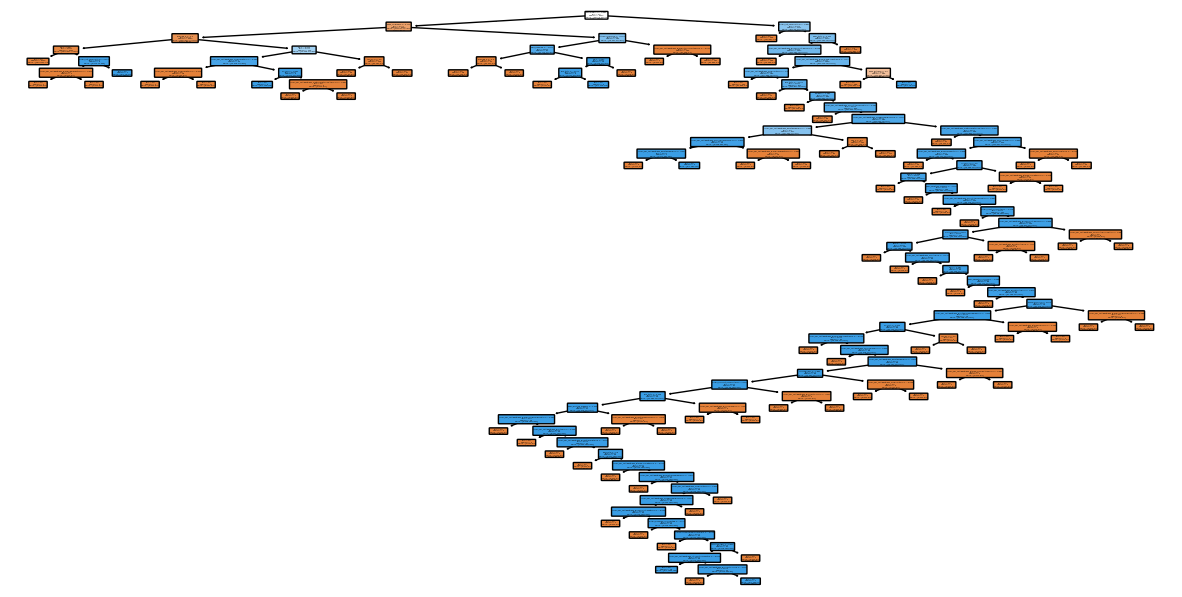

In [ ]:
plt.figure(figsize=(15,7.5)) # (width, height)
plot_tree(clf,
          feature_names=X_train.columns,
          class_names=['No SA', 'Yes SA'],
          filled=True,
          rounded=True)
plt.show()

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_valid, predict, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.99      0.99      0.99      1293
         Yes       0.00      0.00      0.00         9

    accuracy                           0.98      1302
   macro avg       0.50      0.50      0.50      1302
weighted avg       0.99      0.98      0.99      1302



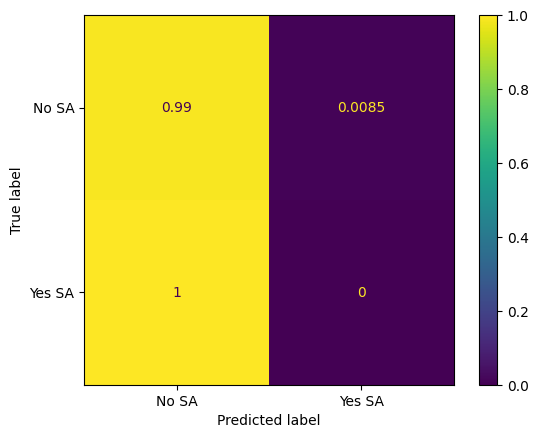

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf, X_valid, y_valid, normalize='true',
                                      display_labels=["No SA", "Yes SA"])

In [ ]:
predict = clf.predict(X_test)
print(metrics.classification_report(y_test, predict, target_names=['No SA', 'Yes SA']))

              precision    recall  f1-score   support

       No SA       0.48      1.00      0.65        10
      Yes SA       0.00      0.00      0.00        11

    accuracy                           0.48        21
   macro avg       0.24      0.50      0.32        21
weighted avg       0.23      0.48      0.31        21



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


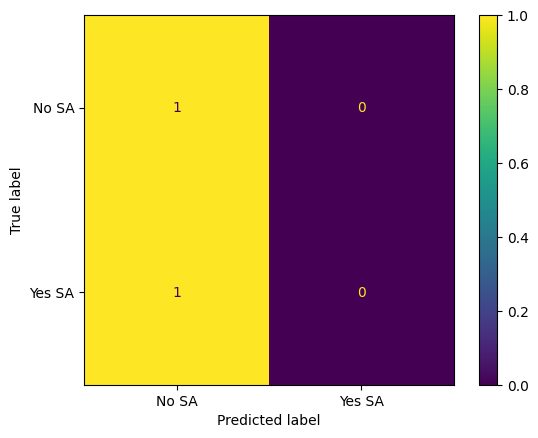

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, normalize='true',
                                      display_labels=["No SA", "Yes SA"])

In [ ]:
feature_names = X_train.columns
importances = clf.feature_importances_
feature_importance = pd.DataFrame(importances, index=feature_names, columns=['importances'])
feature_importance = feature_importance.sort_values('importances', ascending=False)

features = list(feature_importance[feature_importance['importances']>0].index)
len(features)

72

In [ ]:
feature_importance.head()

,importances
Social.CBCL,0.258981
Ne,0.081854
PPSP_frequency,0.074073
nihtbx_list_uncorrected,0.063224
upps_total,0.055966


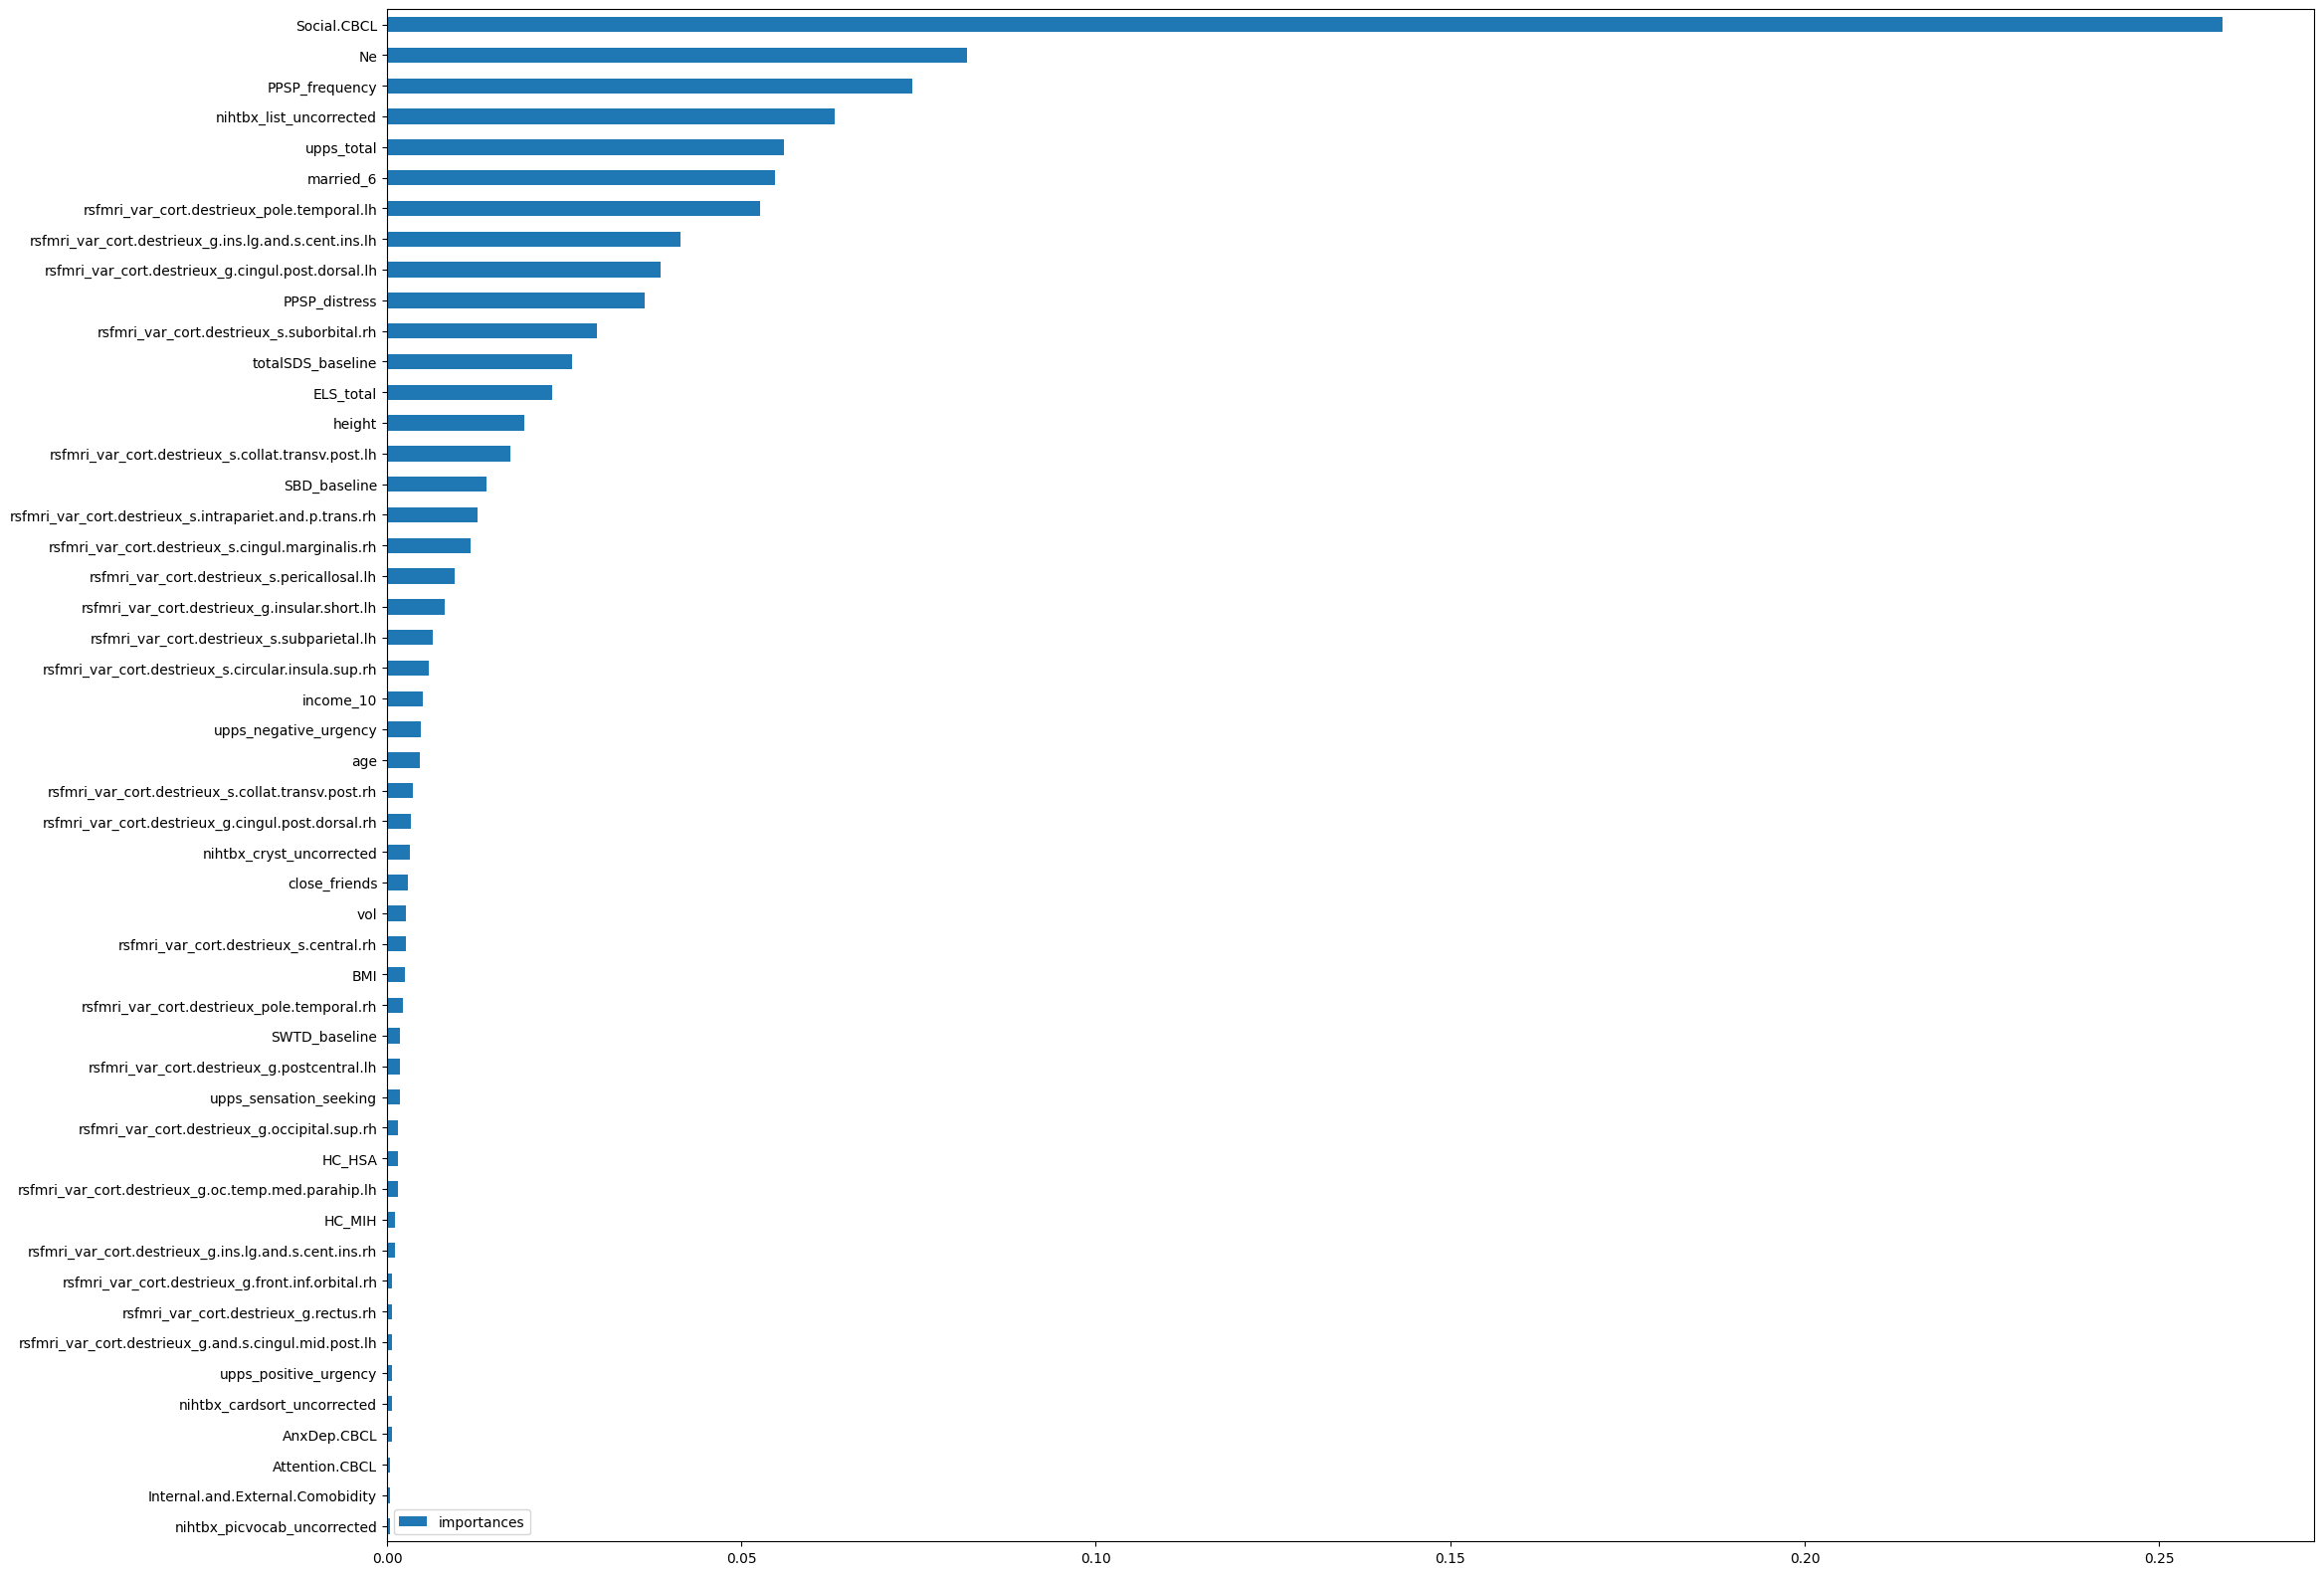

In [ ]:
FI_plot = feature_importance.head(50).plot(figsize=(25,20), kind='barh').invert_yaxis()

## **Cost Complexity Pruning**

### Visualizing Alpha Value

In [ ]:
path = clf.cost_complexity_pruning_path(X_train, y_train) # determine values for alpha
# extract different values of alpha vailable for the tree
ccp_alphas = path.ccp_alphas
# omit max value for alpha or else it would prune ALL leaves
ccp_alphas = ccp_alphas[:-1]

clf_dts = [] # create an array to put DTs into

# build a pruned tree for each value of alpha and store in the array
for ccp_alpha in ccp_alphas:
  clf = DecisionTreeClassifier(random_state=1, class_weight='balanced', ccp_alpha=ccp_alpha)
  clf.fit(X_train, y_train)
  clf_dts.append(clf)

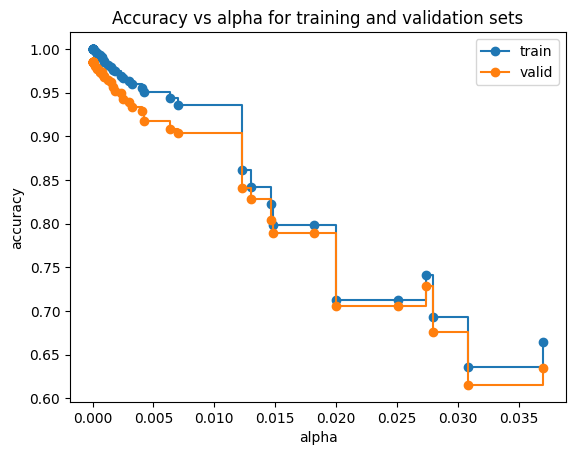

In [ ]:
# graph accuracy of the trees using training and testing dataset as a function of alpha
train_scores = [clf.score(X_train, y_train) for clf in clf_dts]
valid_scores = [clf.score(X_valid, y_valid) for clf in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validation sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="valid", drawstyle="steps-post")
ax.legend()
plt.show()

### CV to Find Best Alpha

In [ ]:
param_grid = {'ccp_alpha': ccp_alphas}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
optimal_params = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=1, class_weight='balanced'),
    param_grid = param_grid,
    scoring = ['recall', 'f1', 'roc_auc'],
    n_jobs=-1,
    cv=cv,
    verbose=2,
    refit='roc_auc')

optimal_params.fit(X_train_q, y_train)

Fitting 30 folds for each of 54 candidates, totalling 1620 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=1),
             n_jobs=-1,
             param_grid={'ccp_alpha': array([0.00000000e+00, 3.22302020e-18, 6.51050080e-18, 3.38631989e-17,
       4.46710600e-17, 4.77866462e-17, 4.77866462e-17, 4.77866462e-17,
       4.77866462e-17, 7.16799692e-17, 8.0607...
       1.47906125e-03, 1.65236668e-03, 1.82224298e-03, 2.34631211e-03,
       2.50010753e-03, 2.97871491e-03, 3.20560027e-03, 4.06743074e-03,
       4.19224426e-03, 6.36119373e-03, 7.00229303e-03, 1.22683423e-02,
       1.30418763e-02, 1.46456203e-02, 1.48594094e-02, 1.82013525e-02,
       2.00250350e-02, 2.51200995e-02, 2.73781771e-02, 2.79829514e-02,
       3.08596206e-02, 3.70363893e-02])},
             refit='roc_auc', scoring=['recall', 'f1', 'roc_auc'], verbose=2)

In [ ]:
results_df = pd.DataFrame(optimal_params.cv_results_)
results_df['mean_metrics'] = results_df[['mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc']].mean(axis=1)

scoring_df = ['param_ccp_alpha', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc', 'mean_metrics']
# results_df[scoring_df]
sorted_df = results_df.sort_values(by=['mean_metrics'], ascending=False)
# sorted_df

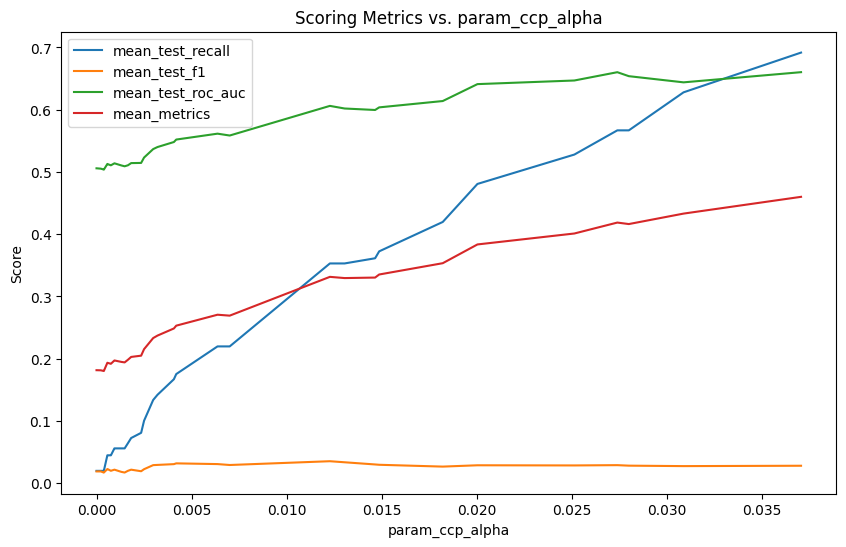

In [ ]:
scoring_metrics = ['mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc', 'mean_metrics']

fig, ax = plt.subplots(figsize=(10, 6))

for metric in scoring_metrics:
    ax.plot(results_df['param_ccp_alpha'], results_df[metric], label=metric)

ax.set_xlabel('param_ccp_alpha')
ax.set_ylabel('Score')
ax.set_title('Scoring Metrics vs. param_ccp_alpha')
ax.legend()
plt.show()

In [ ]:
optimal_params.best_params_
ideal_ccp_alpha = float(optimal_params.best_params_['ccp_alpha'])
ideal_ccp_alpha

0.03703638928243411

0.6824376698570248


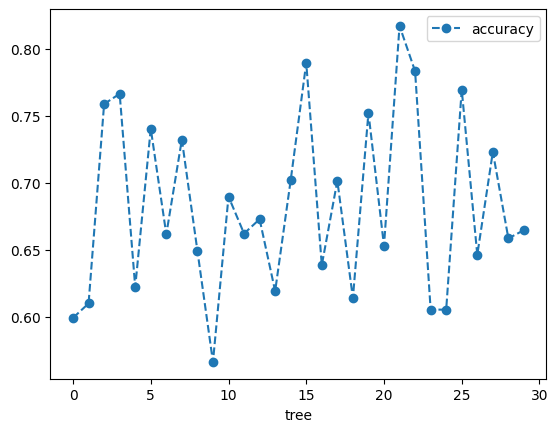

In [ ]:
# create the tree with ccp_alpha = ccp_alphas[-1]
clf = DecisionTreeClassifier(random_state=1, class_weight='balanced', ccp_alpha=ideal_ccp_alpha)

# the graph we drew suggested ONE value for alpha, but another set might suggested another optimal value...
scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
df = pd.DataFrame(data={'tree': range(30), 'accuracy': scores})

# for instance, if we do this with 30-fold CV, see how the accuracy varies by applying the same alpha to all of them
df.plot(x='tree', y='accuracy', marker='o', linestyle='--')
print(scores.mean())

0.6290183178534572


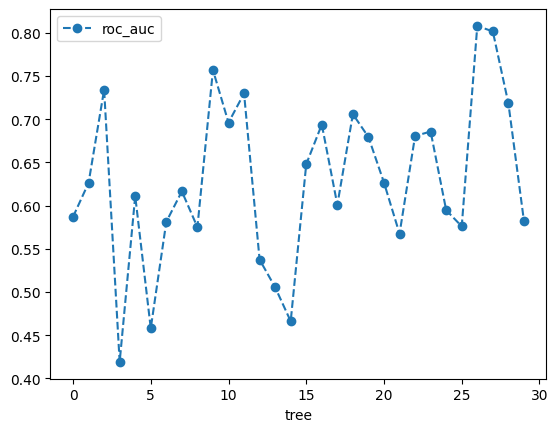

In [ ]:
scores = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
df = pd.DataFrame(data={'tree': range(30), 'roc_auc': scores})

df.plot(x='tree', y='roc_auc', marker='o', linestyle='--')
print(scores.mean())

In [ ]:
# # create array to store results of each fold during CV
# alpha_loop_values = []

# # for each candidate value for alpha, run a 3x10-fold CV
# # store the mean and standard deviation of the accuracy scores
# # for each call to cross_val_score in alpha_loop_values
# for ccp_alpha in ccp_alphas:
#   clf_dt = DecisionTreeClassifier(random_state=1, class_weight='balanced', ccp_alpha=ccp_alpha)
#   scores = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
#   alpha_loop_values.append((ccp_alpha, scores.mean()))

# # for each alpha value, show mean accuracy and std in a dataframe
# alpha_results = pd.DataFrame(alpha_loop_values,
#                              columns=['alpha', 'mean_auc'])
# # plot as graph
# alpha_results.plot(x='alpha', y='mean_auc',  marker='o', linestyle='--')

## **Build, Evaluate, Draw, Interpret the Final DT**

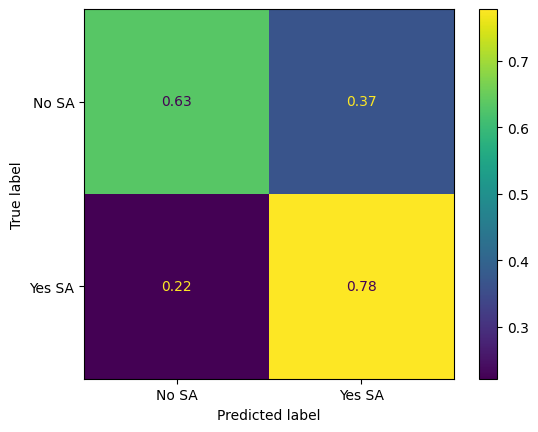

In [ ]:
# build and train new DT w/ optimal value for alpha
clf_dt_pruned = DecisionTreeClassifier(random_state=1, class_weight='balanced', ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(clf_dt_pruned, X_valid, y_valid, normalize='true',
                                      display_labels=["No SA", "Yes SA"])

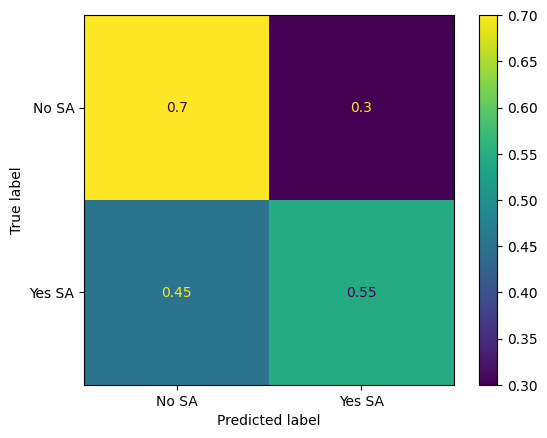

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf_dt_pruned, X_test, y_test, normalize='true',
                                      display_labels=["No SA", "Yes SA"])

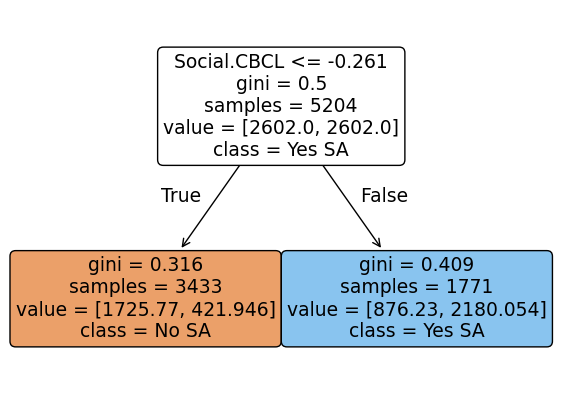

In [ ]:
# plot/draw the pruned tree
plt.figure(figsize=(7,5))
plt.title("Pruned Decision Tree")
plot_tree(clf_dt_pruned,
          feature_names=X_train.columns,
          class_names=["No SA", "Yes SA"],
          filled=True,
          rounded=True)
plt.show()

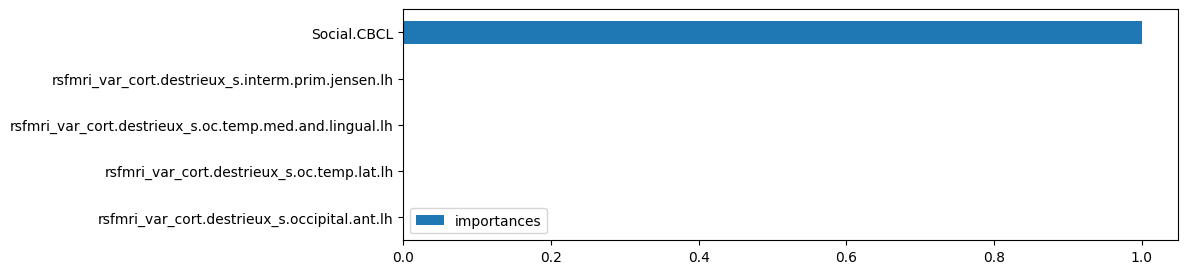

In [ ]:
feature_names = X_train.columns
importances = clf_dt_pruned.feature_importances_
feature_importance = pd.DataFrame(importances, index=feature_names, columns=['importances'])
feature_importance = feature_importance.sort_values('importances', ascending=False)

features = list(feature_importance[feature_importance['importances']>0].index)
FI_plot = feature_importance.head().plot(figsize=(10,3), kind='barh').invert_yaxis()

## **AUC ROC**

In [ ]:
from sklearn.metrics import roc_auc_score
predict_proba = clf_dt_pruned.predict_proba(X_valid)
roc_auc_score(y_valid, predict_proba[:, 1])

0.705594225315803

In [ ]:
predict_proba = clf_dt_pruned.predict_proba(X_test)
roc_auc_score(y_test, predict_proba[:, 1])

0.6227272727272727

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr1, tpr1, thresholds1 = roc_curve(y_test, predict_proba[:,1])
auc1 = auc(fpr1, tpr1)

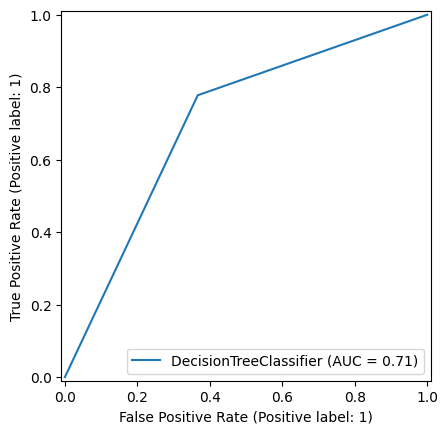

In [ ]:
metrics.RocCurveDisplay.from_estimator(clf_dt_pruned, X_valid, y_valid)

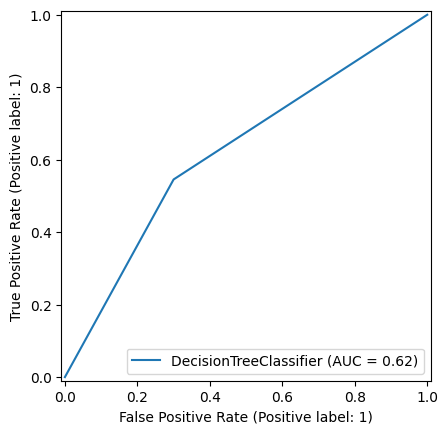

In [ ]:
metrics.RocCurveDisplay.from_estimator(clf_dt_pruned, X_test, y_test)

In [ ]:
predict = clf_dt_pruned.predict(X_valid)
print(metrics.classification_report(y_valid, predict, target_names=['No SA', 'Yes SA']))

              precision    recall  f1-score   support

       No SA       1.00      0.63      0.77      1293
      Yes SA       0.01      0.78      0.03         9

    accuracy                           0.63      1302
   macro avg       0.51      0.71      0.40      1302
weighted avg       0.99      0.63      0.77      1302



In [ ]:
predict = clf_dt_pruned.predict(X_test)
print(metrics.classification_report(y_test, predict, target_names=['No SA', 'Yes SA']))

              precision    recall  f1-score   support

       No SA       0.58      0.70      0.64        10
      Yes SA       0.67      0.55      0.60        11

    accuracy                           0.62        21
   macro avg       0.62      0.62      0.62        21
weighted avg       0.63      0.62      0.62        21



# **Psychosocial ONLY**

## Cost Complexity Pruning

### Visualizing Alpha Value

In [ ]:
path = clf.cost_complexity_pruning_path(X_train_q, y_train) # determine values for alpha
ccp_alphas = path.ccp_alphas
# omit max value for alpha or else it would prune ALL leaves
ccp_alphas = ccp_alphas[:-1]

clf_dts = [] # create an array to put DTs into

# build a pruned tree for each value of alpha and store in the array
for ccp_alpha in ccp_alphas:
  clf = DecisionTreeClassifier(random_state=1, class_weight='balanced', ccp_alpha=ccp_alpha)
  clf.fit(X_train_q, y_train)
  clf_dts.append(clf)
# print(ccp_alphas)

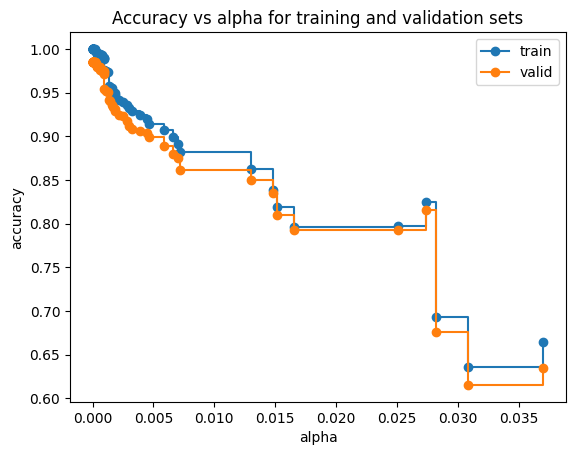

In [ ]:
# graph accuracy of the trees using training and testing dataset as a function of alpha
train_scores = [clf.score(X_train_q, y_train) for clf in clf_dts]
valid_scores = [clf.score(X_valid_q, y_valid) for clf in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validation sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="valid", drawstyle="steps-post")
ax.legend()
plt.show()

### CV to Find Best Alpha

In [ ]:
param_grid = {'ccp_alpha': ccp_alphas}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
optimal_params = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=1, class_weight='balanced'),
    param_grid = param_grid,
    scoring = ['recall', 'f1', 'roc_auc'],
    n_jobs=-1,
    cv=cv,
    verbose=2,
    refit='roc_auc')

optimal_params.fit(X_train_q, y_train)

Fitting 30 folds for each of 80 candidates, totalling 2400 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=1),
             n_jobs=-1,
             param_grid={'ccp_alpha': array([0.00000000e+00, 3.22302020e-18, 1.09045517e-17, 1.09045517e-17,
       1.25697788e-17, 2.05198953e-17, 4.43487579e-17, 4.77866462e-17,
       4.91832882e-17, 4.91832882e-17, 4.9183...
       2.50055239e-03, 2.82937709e-03, 2.97451652e-03, 3.27203081e-03,
       3.88134340e-03, 4.45397914e-03, 4.62556444e-03, 5.82929699e-03,
       6.57720474e-03, 7.00229303e-03, 7.19433485e-03, 1.30418763e-02,
       1.48594094e-02, 1.51826903e-02, 1.65064384e-02, 2.51200995e-02,
       2.73781771e-02, 2.82273766e-02, 3.08596206e-02, 3.70363893e-02])},
             refit='roc_auc', scoring=['recall', 'f1', 'roc_auc'], verbose=2)

In [ ]:
results_df = pd.DataFrame(optimal_params.cv_results_)
results_df['mean_metrics'] = results_df[['mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc']].mean(axis=1)

scoring_df = ['param_ccp_alpha', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc', 'mean_metrics']
# results_df[scoring_df]
sorted_df = results_df[scoring_df].sort_values(by=['mean_metrics'], ascending=False)
sorted_df.head()

,param_ccp_alpha,mean_test_recall,mean_test_f1,mean_test_roc_auc,mean_metrics
79,0.037036,0.691667,0.027651,0.660191,0.459836
78,0.030860,0.627778,0.027064,0.643831,0.432891
76,0.027378,0.566667,0.028606,0.660142,0.418471
77,0.028227,0.566667,0.027447,0.625455,0.406523
75,0.025120,0.527778,0.028153,0.646807,0.400913


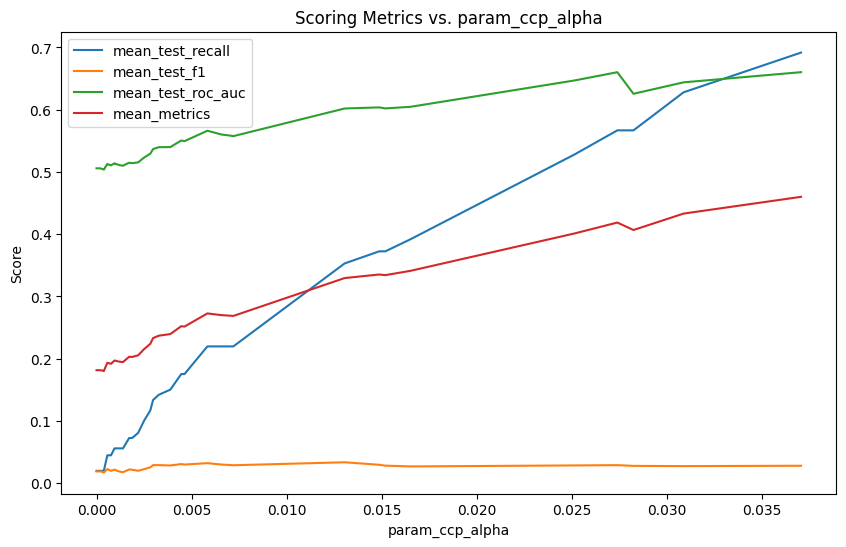

In [ ]:
scoring_metrics = ['mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc', 'mean_metrics']

fig, ax = plt.subplots(figsize=(10, 6))

for metric in scoring_metrics:
    ax.plot(results_df['param_ccp_alpha'], results_df[metric], label=metric)

ax.set_xlabel('param_ccp_alpha')
ax.set_ylabel('Score')
ax.set_title('Scoring Metrics vs. param_ccp_alpha')
ax.legend()
plt.show()

0.6824376698570248


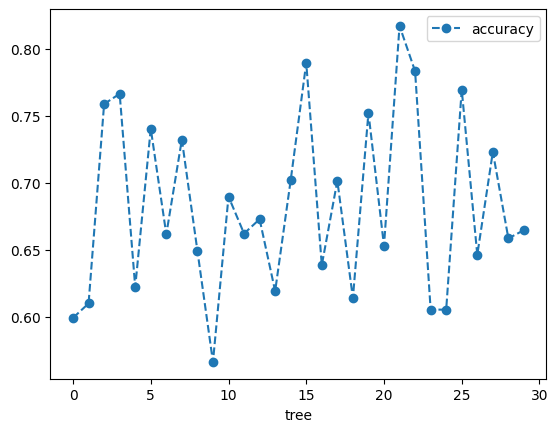

In [ ]:
# create the tree with ccp_alpha = optimal param
# 0.013041876347081498 is best for f1 but 0.037 is better for roc_auc
clf = DecisionTreeClassifier(random_state=1, class_weight='balanced', ccp_alpha=ccp_alphas[-1])

# the graph we drew suggested ONE value for alpha, but another set might suggested another optimal value...
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
df = pd.DataFrame(data={'tree': range(30), 'accuracy': scores})

# for instance, if we do this with 5-fold CV, see how the accuracy varies by applying the same alpha to all of them
df.plot(x='tree', y='accuracy', marker='o', linestyle='--')
print(scores.mean())


0.6290183178534572


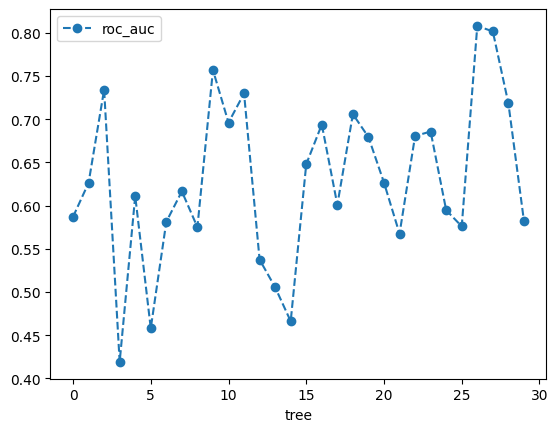

In [ ]:
scores = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
df = pd.DataFrame(data={'tree': range(30), 'roc_auc': scores})

df.plot(x='tree', y='roc_auc', marker='o', linestyle='--')
print(scores.mean())

In [ ]:
ideal_ccp_alpha = float(ccp_alphas[-1])
ideal_ccp_alpha

0.037036389282446125

## Build + Evaluate New Model

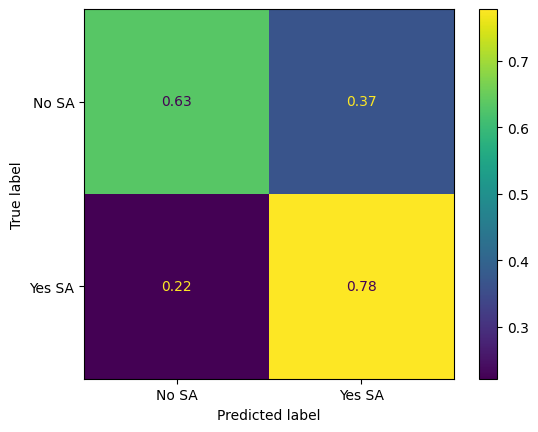

In [ ]:
# build and train new DT w/ optimal value for alpha
clf_dt_pruned = DecisionTreeClassifier(random_state=1, class_weight='balanced', ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned.fit(X_train_q, y_train)
ConfusionMatrixDisplay.from_estimator(clf_dt_pruned, X_valid_q, y_valid, normalize='true',
                                      display_labels=["No SA", "Yes SA"])

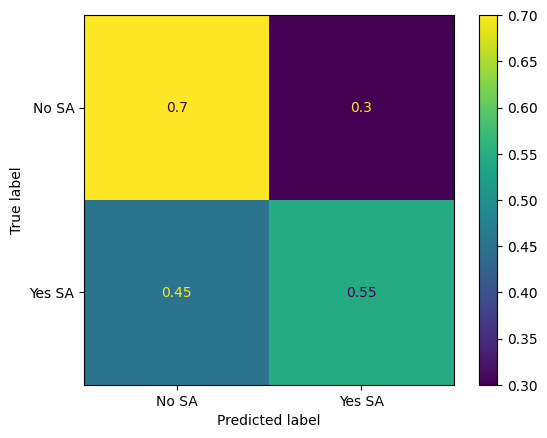

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf_dt_pruned, X_test_q, y_test, normalize='true',
                                      display_labels=["No SA", "Yes SA"])

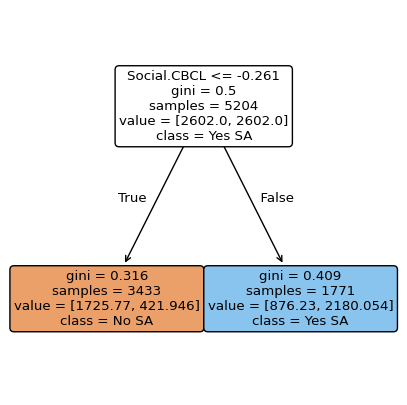

In [ ]:
# plot/draw the pruned tree
plt.figure(figsize=(5,5))
plt.title("Pruned Decision Tree")
plot_tree(clf_dt_pruned,
          feature_names=X_train.columns,
          class_names=["No SA", "Yes SA"],
          filled=True,
          rounded=True)
plt.show()

## Feature Importance

In [ ]:
feature_names_q = X_train_q.columns
importances_q = clf_dt_pruned.feature_importances_
feature_importance_q = pd.DataFrame(importances_q, index=feature_names_q, columns=['importances'])
feature_importance_q = feature_importance_q.sort_values('importances', ascending=False)

features_q = list(feature_importance_q[feature_importance_q['importances']>0].index)
# 'social.CBCL' is the defining feature

## AUC ROC

In [ ]:
predict_proba = clf_dt_pruned.predict_proba(X_valid_q)
roc_auc_score(y_valid, predict_proba[:, 1])


0.705594225315803

In [ ]:
predict_proba = clf_dt_pruned.predict_proba(X_test_q)
roc_auc_score(y_test, predict_proba[:, 1])

0.6227272727272727

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr2, tpr2, thresholds2 = roc_curve(y_test, predict_proba[:,1])
auc2 = auc(fpr2, tpr2)

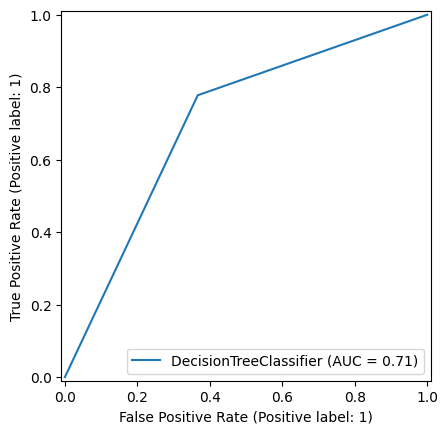

In [ ]:
metrics.RocCurveDisplay.from_estimator(clf_dt_pruned, X_valid_q, y_valid)

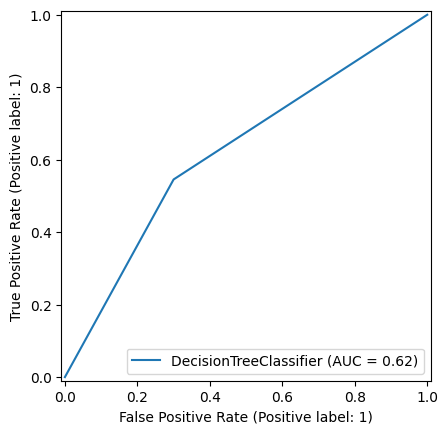

In [ ]:
metrics.RocCurveDisplay.from_estimator(clf_dt_pruned, X_test_q, y_test)

In [ ]:
predict = clf_dt_pruned.predict(X_valid_q)
print(metrics.classification_report(y_valid, predict, target_names=['No SA', 'Yes SA']))

              precision    recall  f1-score   support

       No SA       1.00      0.63      0.77      1293
      Yes SA       0.01      0.78      0.03         9

    accuracy                           0.63      1302
   macro avg       0.51      0.71      0.40      1302
weighted avg       0.99      0.63      0.77      1302



In [ ]:
predict = clf_dt_pruned.predict(X_test_q)
print(metrics.classification_report(y_test, predict, target_names=['No SA', 'Yes SA']))

              precision    recall  f1-score   support

       No SA       0.58      0.70      0.64        10
      Yes SA       0.67      0.55      0.60        11

    accuracy                           0.62        21
   macro avg       0.62      0.62      0.62        21
weighted avg       0.63      0.62      0.62        21



# **fMRI ONLY**

## Cost Complexity Pruning

### Visualizing Alpha Value

In [ ]:
path = clf.cost_complexity_pruning_path(X_train_mri, y_train) # determine values for alpha
ccp_alphas = path.ccp_alphas
# omit max value for alpha or else it would prune ALL leaves
ccp_alphas = ccp_alphas[:-1]

clf_dts = [] # create an array to put DTs into

# build a pruned tree for each value of alpha and store in the array
for ccp_alpha in ccp_alphas:
  clf = DecisionTreeClassifier(random_state=1, class_weight='balanced', ccp_alpha=ccp_alpha)
  clf.fit(X_train_mri, y_train)
  clf_dts.append(clf)
# print(ccp_alphas)

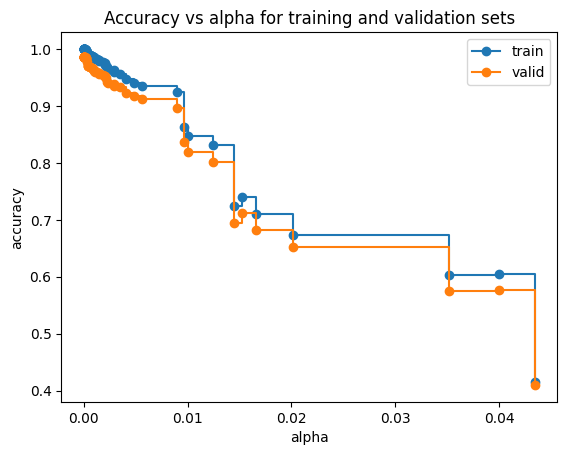

In [ ]:
# graph accuracy of the trees using training and testing dataset as a function of alpha
train_scores = [clf.score(X_train_mri, y_train) for clf in clf_dts]
valid_scores = [clf.score(X_valid_mri, y_valid) for clf in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validation sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="valid", drawstyle="steps-post")
ax.legend()
plt.show()

### CV to Find Best Alpha

In [ ]:
# running this segment takes an extremely long time... will estimate using just a few values.
# ccp_alphas[57::]

param_grid = {'ccp_alpha': ccp_alphas[57::]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
optimal_params = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=1, class_weight='balanced'),
    param_grid = param_grid,
    scoring = ['recall', 'f1', 'roc_auc'],
    n_jobs=-1,
    cv=cv,
    verbose=2,
    refit='roc_auc')

optimal_params.fit(X_train_mri, y_train)

Fitting 30 folds for each of 6 candidates, totalling 180 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=1),
             n_jobs=-1,
             param_grid={'ccp_alpha': array([0.01528294, 0.01663196, 0.02016814, 0.03522633, 0.03996124,
       0.0434417 ])},
             refit='roc_auc', scoring=['recall', 'f1', 'roc_auc'], verbose=2)

In [ ]:
results_df = pd.DataFrame(optimal_params.cv_results_)
results_df['mean_metrics'] = results_df[['mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc']].mean(axis=1)

scoring_df = ['param_ccp_alpha', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc', 'mean_metrics']
# results_df[scoring_df]
sorted_df = results_df[scoring_df].sort_values(by=['mean_metrics'], ascending=False)
sorted_df.head()

,param_ccp_alpha,mean_test_recall,mean_test_f1,mean_test_roc_auc,mean_metrics
4,0.039961,0.516667,0.018074,0.567309,0.367350
5,0.043442,0.525000,0.016627,0.544558,0.362062
3,0.035226,0.455556,0.018362,0.560495,0.344804
2,0.020168,0.302778,0.016126,0.486541,0.268482
1,0.016632,0.213889,0.013259,0.506108,0.244419


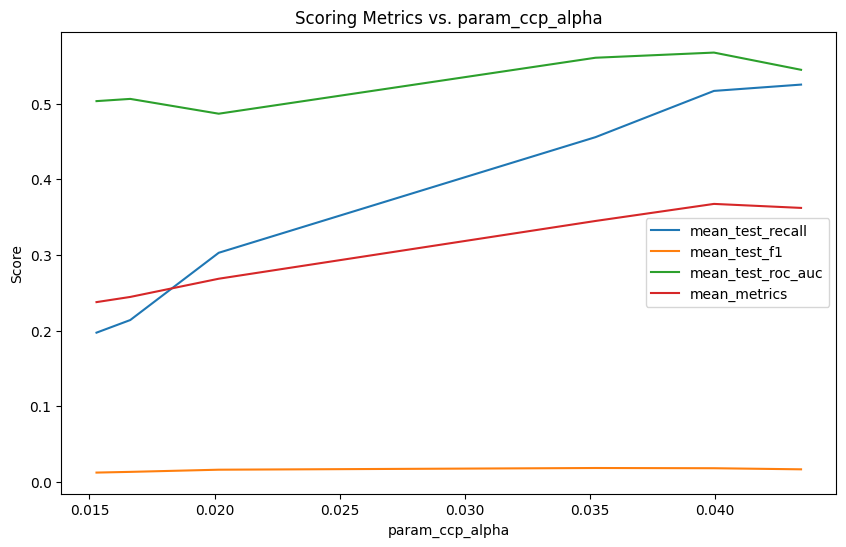

In [ ]:
scoring_metrics = ['mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc', 'mean_metrics']

fig, ax = plt.subplots(figsize=(10, 6))

for metric in scoring_metrics:
    ax.plot(results_df['param_ccp_alpha'], results_df[metric], label=metric)

ax.set_xlabel('param_ccp_alpha')
ax.set_ylabel('Score')
ax.set_title('Scoring Metrics vs. param_ccp_alpha')
ax.legend()
plt.show()

0.6751156012446334


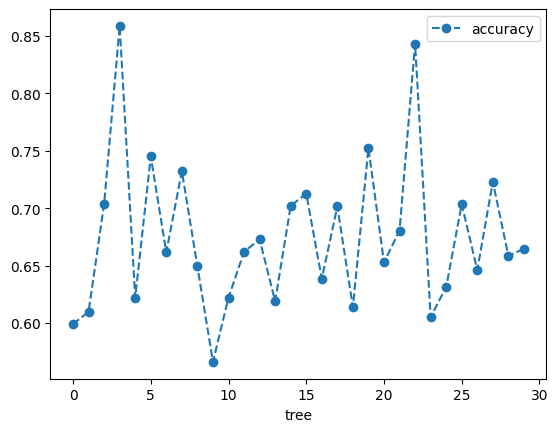

In [ ]:
# create the tree with ccp_alpha = optimal param
ideal_ccp_alpha = float(optimal_params.best_params_['ccp_alpha'])
clf = DecisionTreeClassifier(random_state=1, class_weight='balanced', ccp_alpha=ideal_ccp_alpha)

# the graph we drew suggested ONE value for alpha, but another set might suggested another optimal value...
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
df = pd.DataFrame(data={'tree': range(30), 'accuracy': scores})

# for instance, if we do this with 30-fold CV, see how the accuracy varies by applying the same alpha to all of them
df.plot(x='tree', y='accuracy', marker='o', linestyle='--')
print(scores.mean())


0.6469078947368421


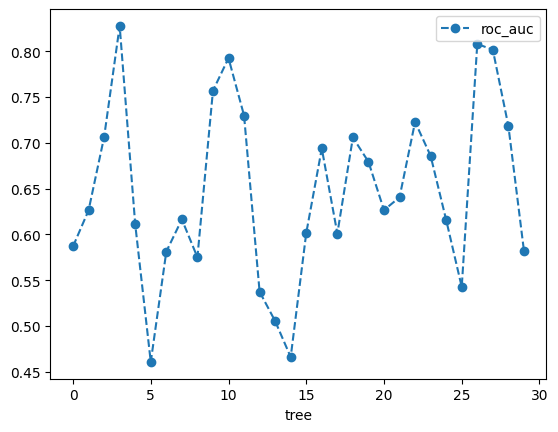

In [ ]:
scores = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
df = pd.DataFrame(data={'tree': range(30), 'roc_auc': scores})

df.plot(x='tree', y='roc_auc', marker='o', linestyle='--')
print(scores.mean())

## Build + Evaluate New Model

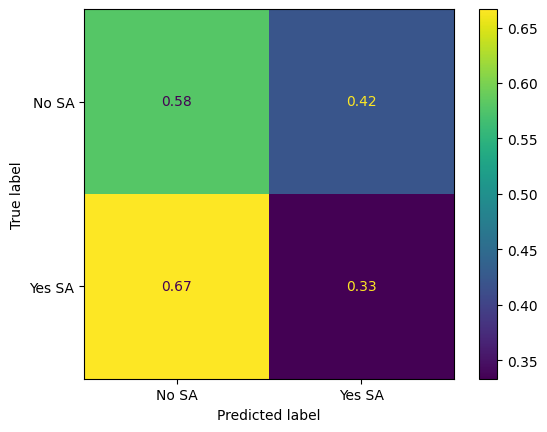

In [ ]:
# build and train new DT w/ optimal value for alpha
clf_dt_pruned = DecisionTreeClassifier(random_state=1, class_weight='balanced', ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned.fit(X_train_mri, y_train)
ConfusionMatrixDisplay.from_estimator(clf_dt_pruned, X_valid_mri, y_valid, normalize='true',
                                      display_labels=["No SA", "Yes SA"])

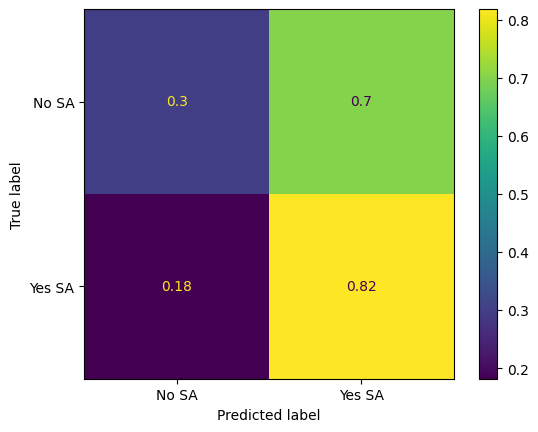

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf_dt_pruned, X_test_mri, y_test, normalize='true',
                                      display_labels=["No SA", "Yes SA"])

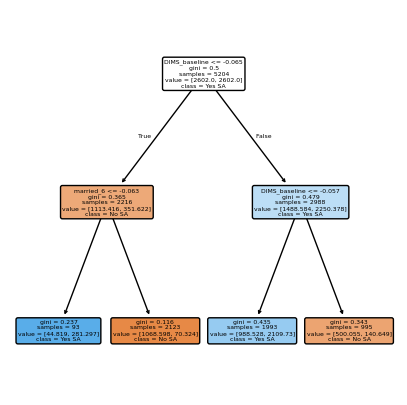

In [ ]:
# plot/draw the pruned tree
plt.figure(figsize=(5,5))
plt.title("Pruned Decision Tree")
plot_tree(clf_dt_pruned,
          feature_names=X_train.columns,
          class_names=["No SA", "Yes SA"],
          filled=True,
          rounded=True)
plt.show()

## Feature Importance

In [ ]:
feature_names_mri = X_train_mri.columns
importances_mri = clf_dt_pruned.feature_importances_
feature_importance_mri = pd.DataFrame(importances_mri, index=feature_names_mri, columns=['importances'])
feature_importance_mri = feature_importance_mri.sort_values('importances', ascending=False)

features_mri = list(feature_importance_mri[feature_importance_mri['importances']>0].index)
# 'social.CBCL' is the defining feature

## AUC ROC

In [ ]:
predict_proba = clf_dt_pruned.predict_proba(X_valid_mri)
roc_auc_score(y_valid, predict_proba[:, 1])

0.3966228409383862

In [ ]:
predict_proba = clf_dt_pruned.predict_proba(X_test_mri)
roc_auc_score(y_test, predict_proba[:, 1])

0.5772727272727274

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr3, tpr3, thresholds3 = roc_curve(y_test, predict_proba[:,1])
auc3 = auc(fpr3, tpr3)

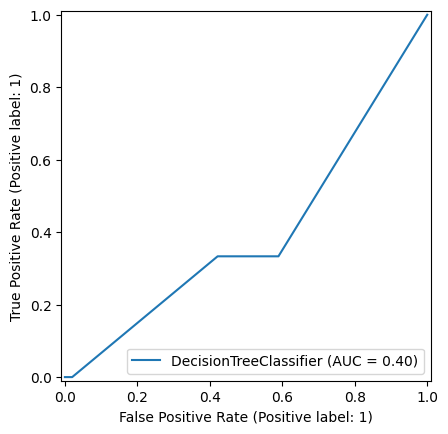

In [ ]:
metrics.RocCurveDisplay.from_estimator(clf_dt_pruned, X_valid_mri, y_valid)

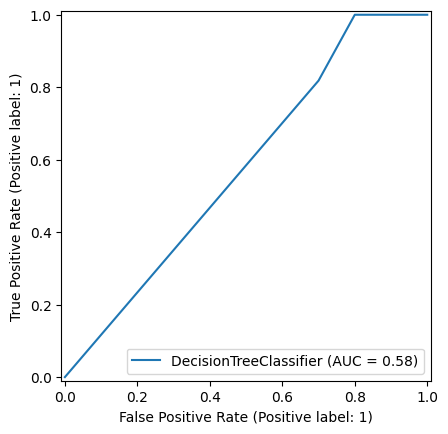

In [ ]:
metrics.RocCurveDisplay.from_estimator(clf_dt_pruned, X_test_mri, y_test)

In [ ]:
predict = clf_dt_pruned.predict(X_valid_mri)
print(metrics.classification_report(y_valid, predict, target_names=['No SA', 'Yes SA']))

              precision    recall  f1-score   support

       No SA       0.99      0.58      0.73      1293
      Yes SA       0.01      0.33      0.01         9

    accuracy                           0.58      1302
   macro avg       0.50      0.46      0.37      1302
weighted avg       0.99      0.58      0.73      1302



In [ ]:
predict = clf_dt_pruned.predict(X_test_mri)
print(metrics.classification_report(y_test, predict, target_names=['No SA', 'Yes SA']))

              precision    recall  f1-score   support

       No SA       0.60      0.30      0.40        10
      Yes SA       0.56      0.82      0.67        11

    accuracy                           0.57        21
   macro avg       0.58      0.56      0.53        21
weighted avg       0.58      0.57      0.54        21



# **Final AUC ROC Curve Compare**

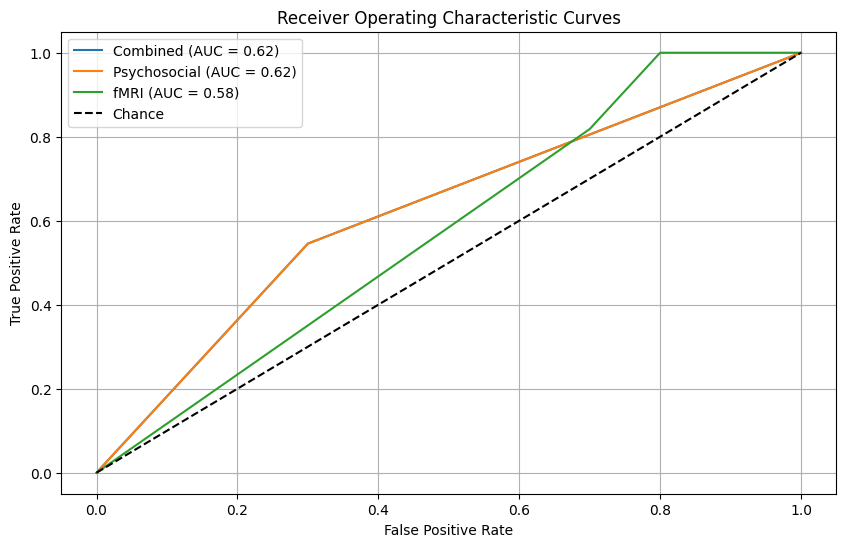

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(fpr1, tpr1, label=f'Combined (AUC = {auc1:.2f})')
plt.plot(fpr2, tpr2, label=f'Psychosocial (AUC = {auc2:.2f})')
plt.plot(fpr3, tpr3, label=f'fMRI (AUC = {auc3:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.legend()
plt.grid(True)
plt.show()